## <center>Appendix-1</center>
## <center>06-606 Project Report - Python Code</center>

The code report consists of the following sections:
    1. Solution of ODE using Scipy odient package (Adams Method)
       1.1 Solver used from odient package
       1.2 Boundary conditions solved using fsolve
       1.3 Time taken for execution of ODE solver
       1.4 Concentration profile
       1.5 Riser temperature profile
       1.6 Conversion along the riser length
       1.7 Yield varying with inlet flow rates
       1.8 Yield vs conversion
       1.9 Gasoline flow rate vs feed inlet temperature
       1.10 fsolve output
       1.11 Odient output (Model Stiffness evaluation)
    2. Manually implemented 4th order Range Kutta Method
       2.1 Manual implementation of 4th order explicit Range Kutta Method
       2.2 Computational Time taken for executing the solver
       2.3 Concentration profile
       2.4 Riser temperature profile
       2.5 Conversion along the riser length
       2.6 Yield vs conversion
    3. Boundary condition using manual implementation of Newtons method
    4. Manually implemented Eulers Method
       4.1 Manual implementation of Eulers method
       4.2 Time taken for executing the solver
       4.3 Concentration profile
       4.4 Riser temperature profile
       4.5 Conversion along riser length
       4.6 Yield vs conversion
    5. Sensitivity Analysis
       5.1 Sensitivity Analysis for Gasoline Flow
           5.1.1 Results obtained
       5.2 Sensitivity Analysis for Maximum feed temperature
           5.2.1 Results obtained
    6. Plots for optimizing critical parameters
       6.1 Variation of Feed Temperature - Riser temperature and Product Flow
       6.2 Variation of Feed flow rate - Riser Temperature
       6.3 Variation of Riser length on Product flow
       6.4 Gasoline production at varying inlet flow rate for different riser length
       
       

# 1. Solution of the system by python buildin packages (scipy.integrate.odeint and scipy.optimize.fsolve)

## 1.1 Solving the ODE equations using Python buildin solver (odeint) - using Adams method since the system is not stiff

Scipy odeint solver evaluates the equation for stiffness and selects the method accordingly. 
BDF solver is used for stiff system and Adams method is used for non stiff system.


## 1.2 Boundary condition is solved using fsolve

odeint fsolve uses Powell’s Hybrid method as implemented in the HYBRJ algorithm in MINPACK using Python odeint fsolve. This algorithm uses dogleg step.

       

In [47]:
import numpy as np
import scipy
from scipy.integrate import odeint 
from scipy import integrate
import matplotlib.pyplot as py
import timeit
import time
from scipy.optimize import fsolve

zspan  = np.linspace(0,33)
Q_overall = 25.7 # kg/sec
Q = 0.945*Q_overall

F_s = 0.055*Q_overall
Ts = 773 #K
T_gasvap = 698 #K
Hvap = 190 # kJ/kg
    
#K0 for components
K0_ab = 1150
K0_ac = 1.79
K0_ad = 426
K0_bc = 0.00059
K0_bd = 426
alpha_0 = 3.6
b_1 = 37311

      
#Case 1 conditions
Q = 25.7 # kg/sec
Feed_T = 494 # K
Cat_T = 1033 # K
    
#Residence time calculation
d_R = 0.8 # m - riser dia
r_r = d_R/2
L_r = 33 # m- riser height
R_a = (np.pi*r_r**2)/4
vel_r = Q/R_a
#t_c = L_r / vel_r # residence time in riser (in sec)
v_s = 6.1 #m/sec as given in paper table 3 
t_c = L_r/v_s
R= 8.314
    
E_coke = 67.21 # KJ/mol given in table1
E_ab = 59.66 # KJ/mol
E_bd = 47.82 
E_ac = 30.95
E_ad = 68.83
E_bc = 57.74
    
Hab = 393
Hbd = 795
Hac = 1200
Had = 1150
Hbc = 151
    
Cp_gasoil = 3.3 #kJ/kgK
Cp_gasoline = 3.3 #kJ/kgK
Cp_Lightgas = 3.3 #kJ/kgK
Cp_coke = 1.087 #kJ/kgK
Cp_steam = 1.9 #kJ/kgK


# Case 1
time_start = time.clock()
count = []
count_fsolve = []
def dydz(y,z):
    ya,yb,yc,yd,T = y
      
    #check whether required
    Kab = K0_ab*np.exp((E_ab)/(R*Feed_T))
    Kbd = K0_bd*np.exp((E_bd)/(R*Feed_T))
    Kac = K0_ac*np.exp((E_ac)/(R*Feed_T))
    Kad = K0_ad*np.exp((E_ad)/(R*Feed_T))
    Kbc = K0_bc*np.exp((E_bc)/(R*Feed_T))

    
    e = 0.8
      
    alpha = alpha_0*np.exp(-E_coke/(R*Feed_T))
    phi = E_coke*np.exp(-alpha*t_c)
    
    rh_s = 960 #kg/m3
    
    #dydt(1) = dyadt, dydt(2) = dybdt, dydt(3) = dyddt, dydt(4) = dycdt
    
    dydz1 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*ya**2 # gas oil
    
    
    dydz2 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*yb-Kab*ya**2) # gasoline

    dydz3 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbd*yb+Kad*ya**2) #% light hydrocarbon gas

    dydz4 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*yb+Kac*ya**2) # coke
        
    dTdz = -((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas
            +Cp_coke+Cp_steam)))*(((ya**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))
            +yb*(Kbc*Hbc+Kbd*Hbd))                                                                                                       
    
    count.append(1)
    return dydz1, dydz2, dydz3, dydz4,dTdz


#####################solving the boundary condition 

def objective(T1):
    sol6 = (F_s*Cp_steam*(T1-Ts) + Q*Cp_gasoil*(T_gasvap-Feed_T)+
            Q*Cp_gasoil*(T1-T_gasvap)+Q*Hvap+(T1-Feed_T))-b_1
    count_fsolve.append(1)
    return sol6
    
s2 = []
guess = 5
s = fsolve(objective,guess)
s, infodict1, ier1, message1 = fsolve(objective, guess 
                            ,args=(),xtol=1e-6,full_output=1)
s12 = s


sol, infodict = scipy.integrate.odeint(dydz,[Q,0,0,0,s[0]],
                                    zspan,full_output=True)

time_elapsed = (time.clock() - time_start)


Q1_overall = 32.7
Q1= 0.945*Q1_overall
sol1, infodict = integrate.odeint(dydz,[Q1,0,0,0,s[0]],
                                  zspan,full_output=True)

Q2_overall = 39.7
Q2= 0.945*Q2_overall

sol2, infodict = integrate.odeint(dydz,[Q2,0,0,0,s[0]],
                                  zspan,full_output=True)

Q3_overall = 42.7
Q3= 0.945*Q3_overall

sol3, infodict = integrate.odeint(dydz,[Q3,0,0,0,s[0]],
                                  zspan,full_output=True)


y = sol[-1,2]/Q


## 1.3 Time taken for execution of ODE solver

In [48]:
print('The time taken for execution of the ODE solver
      using Adams method is {0:1.4f} 
      seconds'.format(np.double(time_elapsed)))

print('The number of iterations pf ODE 
      solver is {0}.'.format(len(count)))

print('The number of iterations of fsolve
      solver is {0}.'.format(len(count_fsolve)))

The time taken for execution of the ODE solver using Adams method is 0.0047 seconds
The number of iterations pf ODE solver is 878.
The number of iterations of fsolve solver is 14.


## 1.4 Concentration Profile

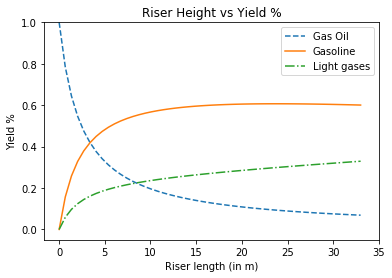

In [49]:
###############Concentration profile
py.plot(zspan,sol[:,0]/Q,'--',
        zspan,sol[:,1]/Q,'-',zspan,sol[:,2]/Q,'-.')
py.ylim(ymax=1)
py.xlim(xmax=35)
py.xlabel('Riser length (in m)')
py.ylabel('Yield %')
py.legend(['Gas Oil','Gasoline','Light gases'])
py.title('Riser Height vs Yield %')
py.savefig('1.png')
py.show()


## 1.5 Riser temperature profile

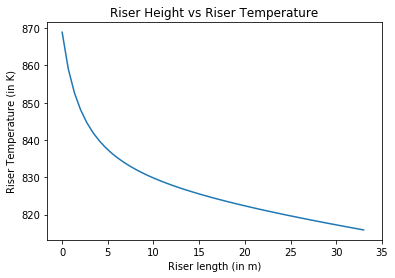

In [50]:
##############Riser temperature profile
py.plot(zspan,sol[:,4])
py.xlim(xmax=35)
py.xlabel('Riser length (in m)')
py.ylabel('Riser Temperature (in K)')
py.title('Riser Height vs Riser Temperature')
py.savefig('2.png')
py.show()


## 1.6 Conversion of Feed

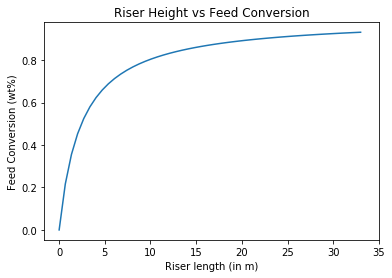

In [51]:
#################Conversion of Feed
py.plot(zspan, 1-sol[:,0]/Q)
py.xlim(xmax=35)
py.xlabel('Riser length (in m)')
py.ylabel('Feed Conversion (wt%)')
py.savefig('3.png')
py.title('Riser Height vs Feed Conversion')
py.show()


## 1.7 Yield for varying inlet flow rates

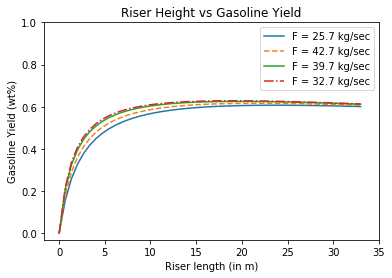

In [52]:
#############Yield for different flow rates

py.plot(zspan,sol[:,1]/Q,zspan,sol1[:,1]/Q1,'--',
        zspan,sol2[:,1]/Q2,'-',zspan,sol3[:,1]/Q3,'-.')
py.ylim(ymax=1)
py.xlim(xmax=35)
py.xlabel('Riser length (in m)')
py.ylabel('Gasoline Yield (wt%)')
py.legend(['F = 25.7 kg/sec','F = 42.7 kg/sec'
           ,'F = 39.7 kg/sec','F = 32.7 kg/sec',])
py.title('Riser Height vs Gasoline Yield')
py.savefig('4.png')
py.show()


## 1.8 Yield vs Conversion

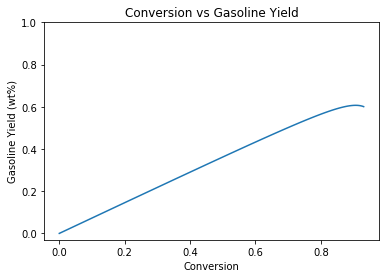

In [40]:
#############Yield vs conversion

py.plot( 1-sol[:,0]/Q,sol[:,1]/Q)
py.ylim(ymax=1)
py.xlabel('Conversion')
py.ylabel('Gasoline Yield (wt%)')
py.title('Conversion vs Gasoline Yield')
py.savefig('5.png')
py.show()


## 1.9 Gasoline flow rate vs feed inlet temperature

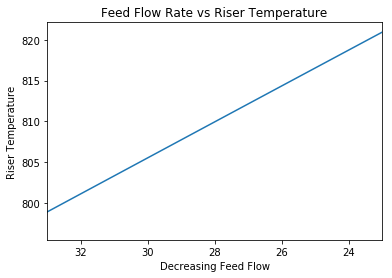

In [41]:
#############Gasoline flow rate  vs temperature
t1 = []
m1=[]
m2=[]
r1 =[]
for m in range(34,22,-1):
    sol = odeint(dydz,[m,0,0,0,868],zspan)
    m1.append(m)
    r1.append(m/3)
    t1.append(sol[-1,4])
for e in m1:
    m2.append(e) 
py.plot(m1,t1)
py.xlim(m1[1],m1[-1])
py.xlabel('Decreasing Feed Flow')
py.ylabel('Riser Temperature')
py.title('Feed Flow Rate vs Riser Temperature')
py.savefig('6.png')
py.show()


## 1.10 fsolve output  

In [42]:
###########output for fsolve statement 

print (infodict1)
print (ier1)
print (message1)

{'nfev': 5, 'fjac': array([[-1.]]), 'r': array([-88.49565]), 'qtf': array([  1.45519152e-11]), 'fvec': array([ 0.])}
1
The solution converged.


## 1.11 odeint output  

In [10]:
print (infodict)

{'hu': array([ 0.05616416,  0.07202068,  0.11331498,  0.15977594,  0.15977594,
        0.21821442,  0.21821442,  0.21821442,  0.29712403,  0.29712403,
        0.29712403,  0.29712403,  0.40570313,  0.40570313,  0.40570313,
        0.40570313,  0.40570313,  0.40570313,  0.55513014,  0.55513014,
        0.55513014,  0.55513014,  0.55513014,  0.55513014,  0.55513014,
        0.76165108,  0.76165108,  0.76165108,  0.76165108,  0.76165108,
        0.76165108,  0.76165108,  0.76165108,  0.76165108,  0.76165108,
        1.04860623,  1.04860623,  1.04860623,  1.04860623,  1.04860623,
        1.04860623,  1.04860623,  1.04860623,  1.04860623,  1.04860623,
        1.04860623,  1.04860623,  1.04860623,  1.04860623]), 'tcur': array([  0.70181789,   1.37445508,   2.12636564,   2.78586247,
         3.42496624,   4.12250848,   4.77715174,   5.431795  ,
         6.16534786,   6.75959591,   7.65096799,   8.24521604,
         8.9480432 ,   9.75944946,  10.16515259,  10.97655884,
        11.7879651 ,  12

As it can be noted in output printed 

"'mused': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1]" 
       
which indicates the system is non stiff and therefore uses Adams method.

---------------------------------------------------------------------------------------------------------------------------------

As it can be seen, the solution converges to give plots similar to data calculated in reference article.

# 2. Manually implemented 4th order Range Kutta Method.

## 2.1 Solution to the differential equations using manually implemented 4th order explicit Range Kutta Method and comparing solution for understanding the stability of the system.

In [11]:
import timeit
import numpy as np
import scipy
from scipy.integrate import odeint 
from scipy import integrate
import matplotlib.pyplot as py
import time

x0= 0
Q = 25.7 # kg/sec
y0= Q
xf = 33
n = 900

delx = (xf-x0)/(n-1)

x = np.linspace(x0,xf,n)
y1 = np.zeros([n])
y2 = np.zeros([n])
y3 = np.zeros([n])
y4 = np.zeros([n])
T = np.zeros([n])


########################
R = 8.314 # J/molK
    
#K0 for components
    
K0_ab = 1150
K0_ac = 1.79
K0_ad = 426
K0_bc = 0.00059
K0_bd = 426
alpha_0 = 3.6################################### constant given in table-1
      
#Case 1 conditions
Q = 25.7 # kg/sec
Feed_T = 494 # K
Cat_T = 1033 # K
    
#Residence time calculation
d_R = 0.8 # m - riser dia
r_r = d_R/2
L_r = 33 # m- riser height
R_a = (np.pi*r_r**2)/4
vel_r = Q/R_a
#t_c = L_r / vel_r # residence time in riser (in sec) --- can alternativly use the superficial velocity given in te table 3
v_s = 6.1 #m/sec as given in paper table 3 
t_c = L_r/v_s
    
E_coke = 67.21 # KJ/mol given in table1
E_ab = 59.66 # KJ/mol
E_bd = 47.82 
E_ac = 30.95
E_ad = 68.83
E_bc = 57.74
    
Hab = 393
Hbd = 795
Hac = 1200
Had = 1150
Hbc = 151
    
Cp_gasoil = 3.3 #kJ/kgK
Cp_gasoline = 3.3 #kJ/kgK
Cp_Lightgas = 3.3 #kJ/kgK
Cp_coke = 1.087 #kJ/kgK
Cp_steam = 1.9 #kJ/kgK
    
#check whether required
Kab = K0_ab*np.exp((E_ab)/(R*Feed_T))
Kbd = K0_bd*np.exp((E_bd)/(R*Feed_T))
Kac = K0_ac*np.exp((E_ac)/(R*Feed_T))
Kad = K0_ad*np.exp((E_ad)/(R*Feed_T))
Kbc = K0_bc*np.exp((E_bc)/(R*Feed_T))

    
    
e = 0.8 # check the assumption
      
alpha = alpha_0*np.exp(-E_coke/(R*Feed_T))
phi = E_coke*np.exp(-alpha*t_c)
    
rh_s = 960 #kg/m3
    
    ####################

y1[0] = y0
y2[0] = 0
y3[0] = 0
y4[0] = 0
T[0] = 868


    
#time =  (timeit.timeit('char in text', setup='text = "sample string"; char = "g"'))
#print('The time taken for execution of the code is {0:1.4f} seconds'.format(np.double(time_elapsed)))
time_start = time.clock()


for i in range(1,n):
    
    k1 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*y1[i-1]**2)
    k2 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*(y1[i-1]+k1/2)**2)
    k3 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*(y1[i-1]+k2/2)**2)
    k4 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*(y1[i-1]+k3)**2)
    y1[i] = (k1+ 2*(k2+k3)+k4)/6 + y1[i-1]
    
    k1_1 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*y2[i-1]-Kab*y1[i]**2))
    k2_1 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*(y2[i-1]+k1/2)-Kab*y1[i]**2))
    k3_1 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*(y2[i-1]+k2/2)-Kab*y1[i]**2))
    k4_1 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*(y2[i-1]+k3)-Kab*y1[i]**2))
    y2[i] = (k1_1+ 2*(k2_1+k3_1)+k4_1)/6 + y2[i-1]
    
    k1_2 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*y2[i]-Kab*y1[i]**2))
    k2_2 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*y2[i]-Kab*y1[i]**2))
    k3_2 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*y2[i]-Kab*y1[i]**2))
    k4_2 = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*y2[i]-Kab*y1[i]**2))
    y3[i] = (k1_2+ 2*(k2_2+k3_2)+k4_2)/6 + y3[i-1]

    k1_3 = delx*(((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*y2[i]+Kac*y1[i]**2))
    k2_3 = delx*(((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*y2[i]+Kac*y1[i]**2))
    k3_3 = delx*(((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*y2[i]+Kac*y1[i]**2))
    k4_3 = delx*(((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*y2[i]+Kac*y1[i]**2))
    y4[i] = (k1_3+ 2*(k2_3+k3_3)+k4_3)/6 + y4[i-1]
    
    
    k1_4 = delx*(-((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((y1[i]**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+y2[i]*(Kbc*Hbc+Kbd*Hbd))) 
    k2_4 = delx*(-((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((y1[i]**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+y2[i]*(Kbc*Hbc+Kbd*Hbd))) 
    k3_4 = delx*(-((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((y1[i]**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+y2[i]*(Kbc*Hbc+Kbd*Hbd))) 
    k4_4 = delx*(-((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((y1[i]**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+y2[i]*(Kbc*Hbc+Kbd*Hbd))) 
    T[i] = (k1_4+ 2*(k2_4+k3_4)+k4_4)/6 + T[i-1]
    
    
#time =  (timeit.timeit('char in text', setup='text = "sample string"; char = "g"'))   

time_elapsed = (time.clock() - time_start)


## 2.2 Computational time for executing 4th order Range Kutta Method

In [12]:
print('The time taken for execution of the code is {0:1.4f} seconds'.format(np.double(time_elapsed)))
print('The number of iterations is {0}.'.format(900))

The time taken for execution of the code is 0.0441 seconds
The number of iterations is 900.


## 2.3 Concentration Profile 

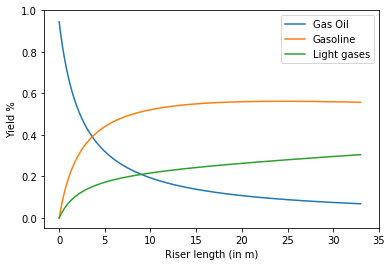

In [44]:
 ###############Concentration profile
py.plot(x,y1/Q)
py.plot(x,y2/Q)
py.plot(x,y3/Q)
py.ylim(ymax=1)
py.xlim(xmax=35)
py.xlabel('Riser length (in m)')
py.ylabel('Yield %')
py.legend(['Gas Oil','Gasoline','Light gases'])
py.savefig('7.png')
py.show()


## 2.4 Riser temperature Profile

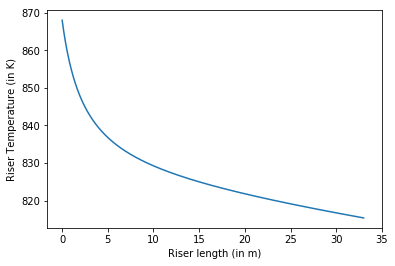

In [14]:
##############Riser temperature profile
py.plot(x,T)
py.xlim(xmax=35)
py.xlabel('Riser length (in m)')
py.ylabel('Riser Temperature (in K)')
py.savefig('8.png')
py.show()


## 2.5 Conversion along length of riser

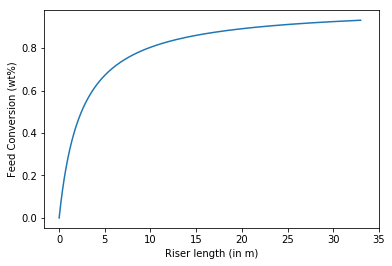

In [15]:
#################Conversion of Feed
py.plot(x, 1-y1/Q)
py.xlim(xmax=35)
py.xlabel('Riser length (in m)')
py.ylabel('Feed Conversion (wt%)')
py.savefig('9.png')
py.show()


## 2.6 Yield vs Conversion

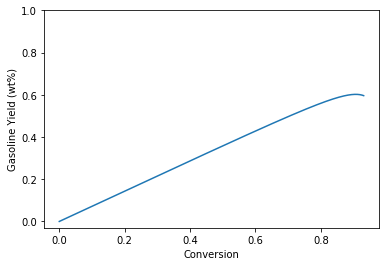

In [16]:
#############Yield vs conversion

py.plot( 1-y1/Q,y2/Q)
py.xlabel('Conversion')
py.ylabel('Gasoline Yield (wt%)')
py.ylim(ymax=1)
py.savefig('10.png')
py.show()


As it can be seen the profiles obtained for both the methods are identical.

# 3. Boundary condition solution using Newtons Method (manually implemeted)

The equation was manually solved using Newtons method to understand the stability of the Linear boudary condition with Newtons Raphson method. The number of iterations required for reaching the required accuracy of the solution was assessed.

In [17]:
####### 12032017 10.58 pm
import numpy as np
import scipy
from scipy.integrate import odeint 
from scipy import integrate
import matplotlib.pyplot as py
import timeit
from scipy.optimize import fsolve

zspan  = np.linspace(0,33)
Q_overall = 25.7 # kg/sec
Q = 0.945*Q_overall

F_s = 0.055*Q_overall
Ts = 773 #K
T_gasvap = 698 #K
Hvap = 190 # kJ/kg
    
#K0 for components
    
K0_ab = 1150
K0_ac = 1.79
K0_ad = 426
K0_bc = 0.00059
K0_bd = 426
alpha_0 = 3.6
b_1 = 37311

      
#Case 1 conditions
Q = 25.7 # kg/sec
Feed_T = 494 # K
Cat_T = 1033 # K
    
#Residence time calculation
d_R = 0.8 # m - riser dia
r_r = d_R/2
L_r = 33 # m- riser height
R_a = (np.pi*r_r**2)/4
vel_r = Q/R_a
v_s = 6.1 #m/sec as given in table 3 
t_c = L_r/v_s
    
E_coke = 67.21 # KJ/mol given in table1
E_ab = 59.66 # KJ/mol
E_bd = 47.82 
E_ac = 30.95
E_ad = 68.83
E_bc = 57.74
    
Hab = 393
Hbd = 795
Hac = 1200
Had = 1150
Hbc = 151
    
Cp_gasoil = 3.3 #kJ/kgK
Cp_gasoline = 3.3 #kJ/kgK
Cp_Lightgas = 3.3 #kJ/kgK
Cp_coke = 1.087 #kJ/kgK
Cp_steam = 1.9 #kJ/kgK


# Case 1

#####################solving the boundary condition 

def objective(T1):
    sol6 = (F_s*Cp_steam*(T1-Ts) + Q*Cp_gasoil*(T_gasvap-Feed_T)+Q*Cp_gasoil*(T1-T_gasvap)+Q*Hvap+(T1-Feed_T))-b_1
    
    return sol6

T5 =500

for i in range(0,1000):
    diff = F_s*Cp_steam +Q*Cp_gasoil+1
    T6 = T5 -  ((F_s*Cp_steam*(T5-Ts) + Q*Cp_gasoil*(T_gasvap-Feed_T)+Q*Cp_gasoil*(T5-T_gasvap)+Q*Hvap+(T5-Feed_T))-b_1)/diff
    T5 = T6
    if np.abs(s12-T5)<1e-20:
        break
        

print ('The solution is reaching convergance in {0} iteration'.format(i+1))



s  = fsolve(objective,5,full_output=True)
print ('The value of temperature obtained is {0:1.4f} K'.format(np.double(s[0])))

The solution is reaching convergance in 1 iteration
The value of temperature obtained is 868.9031 K


The solution reached an error less than 0.00001 in one iteration, and solution obtained by manual implementation of Newtons method is same as the solution obtined by odient fsolve.

# 4. Manually implemented Eulers Method.

## 4.1 Solution to the differential equations using manually implemented Eulers Method and comparing solution for understanding the stability of the system.

In [18]:
import numpy as np
import scipy
from scipy.integrate import odeint 
from scipy import integrate
import matplotlib.pyplot as py
import time

x0= 0
Q_overall = 25.7 # kg/sec
Q= 0.945*Q_overall
y0= Q
xf = 33
n = 900

delx = (xf-x0)/(n-1)

x = np.linspace(x0,xf,n)
y1 = np.zeros([n])
y2 = np.zeros([n])
y3 = np.zeros([n])
y4 = np.zeros([n])
T = np.zeros([n])


########################
R = 8.314 # J/molK
    
#K0 for components
    
K0_ab = 1150
K0_ac = 1.79
K0_ad = 426
K0_bc = 0.00059
K0_bd = 426
alpha_0 = 3.6################################### constant given in table-1
      
#Case 1 conditions
Q = 25.7 # kg/sec
Feed_T = 494 # K
Cat_T = 1033 # K
    
#Residence time calculation
d_R = 0.8 # m - riser dia
r_r = d_R/2
L_r = 33 # m- riser height
R_a = (np.pi*r_r**2)/4
vel_r = Q/R_a
v_s = 6.1 #m/sec as given in paper table 3 
t_c = L_r/v_s
    
E_coke = 67.21 # KJ/mol given in table1
E_ab = 59.66 # KJ/mol
E_bd = 47.82 
E_ac = 30.95
E_ad = 68.83
E_bc = 57.74
    
Hab = 393
Hbd = 795
Hac = 1200
Had = 1150
Hbc = 151
    
Cp_gasoil = 3.3 #kJ/kgK
Cp_gasoline = 3.3 #kJ/kgK
Cp_Lightgas = 3.3 #kJ/kgK
Cp_coke = 1.087 #kJ/kgK
Cp_steam = 1.9 #kJ/kgK
    
#check whether required
Kab = K0_ab*np.exp((E_ab)/(R*Feed_T))
Kbd = K0_bd*np.exp((E_bd)/(R*Feed_T))
Kac = K0_ac*np.exp((E_ac)/(R*Feed_T))
Kad = K0_ad*np.exp((E_ad)/(R*Feed_T))
Kbc = K0_bc*np.exp((E_bc)/(R*Feed_T))

    
    
e = 0.8 # check the assumption
      
alpha = alpha_0*np.exp(-E_coke/(R*Feed_T))
phi = E_coke*np.exp(-alpha*t_c)
    
rh_s = 960 #kg/m3
    
    ####################

y1[0] = y0
y2[0] = 0
y3[0] = 0
y4[0] = 0
T[0] = 868

time_start = time.clock()

for i in range(1,n):
    y1[i] = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*y1[i-1]**2)+ y1[i-1]
        
    y2[i] = delx*(-((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*y2[i-1]-Kab*y1[i]**2))+ y2[i-1] # gasoline

    y3[i] = delx*(((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbd*y2[i]+Kad*y1[i]**2))+ y3[i-1] #% light hydrocarbon gas

    y4[i] = delx*(((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*y2[i]+Kac*y1[i]**2))+ y4[i-1] # coke
    
    T[i] = delx*(-((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((y1[i-1]**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+y2[i-1]*(Kbc*Hbc+Kbd*Hbd))) + T[i-1]                           
    
    if np.abs(y3[i]-y3[i-1])<0.01 and np.abs(y1[i]-y1[i-1])<0.01 and np.abs(y2[i]-y2[i-1])<0.01 and np.abs(y4[i]-y4[i-1])<0.01 and np.abs(T[i]-T[i-1])<0.01:
        break
        
time_elapsed = (time.clock() - time_start)

## 4.2 Computational time for executing  Eulers Method

In [19]:
print('The time taken for execution of the code is {0:1.4f} seconds'.format(np.double(time_elapsed)))


The time taken for execution of the code is 0.0189 seconds


## 4.3 Concentration Profile

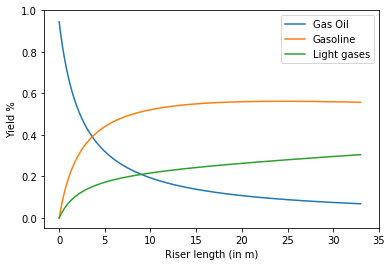

In [45]:
###############Concentration profile
py.plot(x,y1/Q,x,y2/Q,x,y3/Q)
py.ylim(ymax=1)
py.xlim(xmax=35)
py.xlabel('Riser length (in m)')
py.ylabel('Yield %')
py.legend(['Gas Oil','Gasoline','Light gases'])
py.savefig('11.png')
py.show()


## 4.4 Riser temperature profile

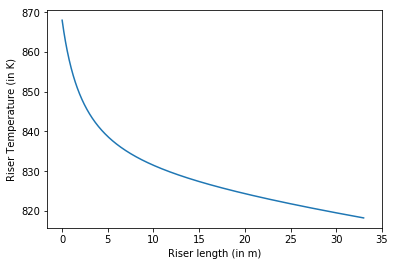

In [21]:
##############Riser temperature profile
py.plot(x,T)
py.xlim(xmax=35)
py.xlabel('Riser length (in m)')
py.ylabel('Riser Temperature (in K)')
py.savefig('12.png')
py.show()

## 4.5 Conversion along length of riser

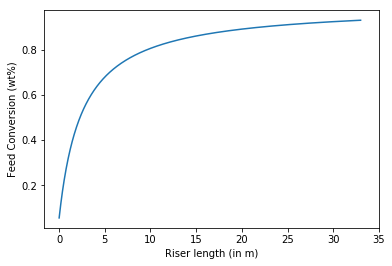

In [22]:
#################Conversion of Feed
py.plot(x, 1-y1/Q)
py.xlabel('Riser length (in m)')
py.ylabel('Feed Conversion (wt%)')
py.xlim(xmax=35)
py.savefig('13.png')
py.show()

## 4.6 Yield vs Conversion

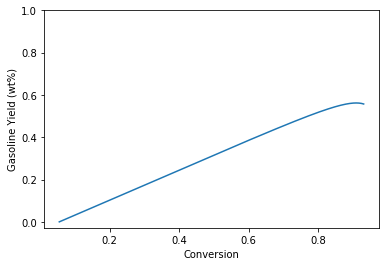

In [23]:
#############Yield vs conversion

py.plot( 1-y1/Q,y2/Q)
py.xlabel('Conversion')
py.ylabel('Gasoline Yield (wt%)')
py.ylim(ymax=1)
py.savefig('14.png')
py.show()

# 5. Sensitivity Analysis

## 5.1 SENSITIVITY ANALYSIS - for gasoline flow

Sensitivity analysis for gasoline flow, assuming no interation between the parmeters analysed. Detailed comparison is provided in report.

In [24]:
import numpy as np
import scipy
from scipy.integrate import odeint 
from scipy import integrate
import matplotlib.pyplot as py
import timeit
from scipy.optimize import fsolve


#L_r = 33 # m- riser height

#Q_overall = 25.7 # kg/sec
#Ts = 773 #K
#T_gasvap = 698 #K
#Hvap = 190 # kJ/kg
R = 8.413
    
#K0 for components
    
#K0_ab = 1150
#K0_ac = 1.79
#K0_ad = 426
#K0_bc = 0.00059
#K0_bd = 426
#alpha_0 = 3.6
#b_1 = 37311

p0 = [773,698,190,1150,1.79,426,0.00059,426,3.6,37311,25.7,494,1033,0.8,6.1,67.21,59.66,47.82,30.95,68.83,57.74,393,
      795,1200,1150,151,3.3,3.3,3.3,1.087,1.9,33]

      
#Case 1 conditions
#Feed_T = 494 # K
#Cat_T = 1033 # K
    
#Residence time calculation
#d_R = 0.8 # m - riser dia

#t_c = L_r / vel_r # residence time in riser (in sec) 
#v_s = 6.1 #m/sec as given in paper table 3 

    
#E_coke = 67.21 # KJ/mol given in table1
#E_ab = 59.66 # KJ/mol
#E_bd = 47.82 
#E_ac = 30.95
#E_ad = 68.83
#E_bc = 57.74
    
#Hab = 393
#Hbd = 795
#Hac = 1200
#Had = 1150
#Hbc = 151
    
#Cp_gasoil = 3.3 #kJ/kgK
#Cp_gasoline = 3.3 #kJ/kgK
#Cp_Lightgas = 3.3 #kJ/kgK
#Cp_coke = 1.087 #kJ/kgK
#Cp_steam = 1.9 #kJ/kgK


# Case 1

def model(parameters):
    (Ts,T_gasvap,Hvap,K0_ab,K0_ac,K0_ad,K0_bc,K0_bd,alpha_0,b_1,Q_overall,Feed_T,Cat_T,d_R,v_s,E_coke,E_ab,E_bd,E_ac,E_ad,E_bc,
     Hab,Hbd,Hac,Had,Hbc,Cp_gasoil,Cp_gasoline,Cp_Lightgas,Cp_coke,Cp_steam,L_r) =parameters ###all excepy L_r 
    Q = 0.945*Q_overall
    F_s = 0.055*Q_overall
    r_r = d_R/2
    R_a = (np.pi*r_r**2)/4
    vel_r = Q/R_a
    t_c = L_r/v_s
    zspan  = np.linspace(0,L_r)
    def dydz(y,z):
        ya,yb,yc,yd,T = y
          
        #check whether required
        Kab = K0_ab*np.exp((E_ab)/(R*Feed_T))
        Kbd = K0_bd*np.exp((E_bd)/(R*Feed_T))
        Kac = K0_ac*np.exp((E_ac)/(R*Feed_T))
        Kad = K0_ad*np.exp((E_ad)/(R*Feed_T))
        Kbc = K0_bc*np.exp((E_bc)/(R*Feed_T))

        e = 0.8 # check the assumption

        alpha = alpha_0*np.exp(-E_coke/(R*Feed_T))
        phi = E_coke*np.exp(-alpha*t_c)

        rh_s = 960 #kg/m3

        #dydt(1) = dyadt, dydt(2) = dybdt, dydt(3) = dyddt, dydt(4) = dycdt

        dydz1 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*ya**2 # gas oil


        dydz2 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*yb-Kab*ya**2) # gasoline

        dydz3 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbd*yb+Kad*ya**2) #% light hydrocarbon gas

        dydz4 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*yb+Kac*ya**2) # coke

        dTdz = -((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((ya**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+yb*(Kbc*Hbc+Kbd*Hbd))                                                                                                       
        return dydz1, dydz2, dydz3, dydz4,dTdz
    
    
    def objective(T1):
        sol6 = (F_s*Cp_steam*(T1-Ts) + Q*Cp_gasoil*(T_gasvap-Feed_T)+Q*Cp_gasoil*(T1-T_gasvap)+Q*Hvap+(T1-Feed_T))-b_1
        return sol6
    
    s2 = []
    s = fsolve(objective,5)

    sol, infodict = scipy.integrate.odeint(dydz,[Q,0,0,0,s[0]],zspan,full_output=True)


    T = sol[:, 4]
    Gasoline_flow  =sol[:,1]
    return np.max(Gasoline_flow)


import numdifftools as nd
df=nd.Gradient(model)
df(p0)*p0/model(p0)    



/opt/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.35167605e-01,  -1.02770208e-03,  -2.46821038e-01,
        -1.18646766e-07,  -8.54627524e-02,   6.15018589e-03,
         0.00000000e+00,   1.08546287e+00,  -3.07789785e-04,
         0.00000000e+00,   1.46946351e-04,   3.55528553e-02,
         2.43116291e-03,   4.81135550e-03,  -9.83351103e-04,
        -7.65332317e-06,  -4.08772910e-03,  -1.64837364e-09,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   9.72268997e-04])

### 5.1.1 Sensitivity analysis results obtained:

During sensitivity analysis numerical values (not zero) was obtained for the following varibles:

Gasoil to gasoline (K0_ab) : 3.35e-01

Gas oil to coke (K0_ac) -: -1.03e-03

Gasoline to light gases (K0_ad) : -2.47e-01

Gasoline to coke (K0_bc) : -1.18646766e-07

Gas oil to light gases (K0_bd) : -8.54e-02

Decay Constant (alpha_0) : 6.15018589e-03

Inlet flow rate (Q_overall) : 1.08546287e+00

Feed Temperature (Feed_T) : -3.07789785e-04

Riser Diameter (d_R) : 1.46946351e-04

Superficial velocity (v_s) : 3.55528553e-02

Activation energy of coke (for deactivation ) (E_coke) : 2.43116291e-03

Activation energy of Gas oil to gasoline  (E_ab) : 4.81135550e-03

Activation energy of gasoil to light gasses (E_bd) : -9.83351103e-04

Activation energy of gas oil to coke (E_ac) : -7.65332317e-06

Activation energy of gasoline to light gases (E_ad) : -4.08772910e-03

Activation energy of Gasoline to coke (KE_bc) : -1.64837364e-09

Riser Length (L_r) : 9.72268997e-04


## 5.2 SENSITIVITY ANALYSIS - for maximum feed temperature

Sensitivity analysis for maximum temperature, assuming no interation between the parmeters analysed. Detailed comparison is provided in report.

In [25]:

####### 12032017 10.58 pm
import numpy as np
import scipy
from scipy.integrate import odeint 
from scipy import integrate
import matplotlib.pyplot as py
import timeit
from scipy.optimize import fsolve

#Q_overall = 25.7 # kg/sec
#Ts = 773 #K
#T_gasvap = 698 #K
#Hvap = 190 # kJ/kg
R = 8.413
    
#K0 for components
    
#K0_ab = 1150
#K0_ac = 1.79
#K0_ad = 426
#K0_bc = 0.00059
#K0_bd = 426
#alpha_0 = 3.6################################### constant given in table-1
#b_1 = 37311

#L_r = 33 # m- riser height


p0 = [773,698,190,1150,1.79,426,0.00059,426,3.6,37311,25.7,494,1033,0.8,6.1,67.21,59.66,47.82,30.95,68.83,57.74,393,
      795,1200,1150,151,3.3,3.3,3.3,1.087,1.9,33]

#Case 1 conditions
#Feed_T = 494 # K
#Cat_T = 1033 # K
    
#Residence time calculation
#d_R = 0.8 # m - riser dia

#t_c = L_r / vel_r # residence time in riser (in sec) --- can alternativly use the superficial velocity given in te table 3
#v_s = 6.1 #m/sec as given in paper table 3 

    
#E_coke = 67.21 # KJ/mol given in table1
#E_ab = 59.66 # KJ/mol
#E_bd = 47.82 
#E_ac = 30.95
#E_ad = 68.83
#E_bc = 57.74
    
#Hab = 393
#Hbd = 795
#Hac = 1200
#Had = 1150
#Hbc = 151
    
#Cp_gasoil = 3.3 #kJ/kgK
#Cp_gasoline = 3.3 #kJ/kgK
#Cp_Lightgas = 3.3 #kJ/kgK
#Cp_coke = 1.087 #kJ/kgK
#Cp_steam = 1.9 #kJ/kgK


# Case 1

#####################solving the boundary condition 
def model(parameters):
    (Ts,T_gasvap,Hvap,K0_ab,K0_ac,K0_ad,K0_bc,K0_bd,alpha_0,b_1,Q_overall,Feed_T,Cat_T,d_R,v_s,E_coke,E_ab,E_bd,E_ac,E_ad,E_bc,
     Hab,Hbd,Hac,Had,Hbc,Cp_gasoil,Cp_gasoline,Cp_Lightgas,Cp_coke,Cp_steam,L_r) =parameters ###all except L_r 
    zspan  = np.linspace(0,L_r)

    Q = 0.945*Q_overall
    F_s = 0.055*Q_overall
    r_r = d_R/2
    R_a = (np.pi*r_r**2)/4
    vel_r = Q/R_a
    t_c = L_r/v_s
    
    def dydz(y,z):
        ya,yb,yc,yd,T = y
      
        #check whether required
        Kab = K0_ab*np.exp((E_ab)/(R*Feed_T))
        Kbd = K0_bd*np.exp((E_bd)/(R*Feed_T))
        Kac = K0_ac*np.exp((E_ac)/(R*Feed_T))
        Kad = K0_ad*np.exp((E_ad)/(R*Feed_T))
        Kbc = K0_bc*np.exp((E_bc)/(R*Feed_T))

        e = 0.8 # check the assumption

        alpha = alpha_0*np.exp(-E_coke/(R*Feed_T))
        phi = E_coke*np.exp(-alpha*t_c)

        rh_s = 960 #kg/m3

        #dydt(1) = dyadt, dydt(2) = dybdt, dydt(3) = dyddt, dydt(4) = dycdt

        dydz1 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*ya**2 # gas oil


        dydz2 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*yb-Kab*ya**2) # gasoline

        dydz3 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbd*yb+Kad*ya**2) #% light hydrocarbon gas

        dydz4 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*yb+Kac*ya**2) # coke

        dTdz = -((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((ya**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+yb*(Kbc*Hbc+Kbd*Hbd))                                                                                                       
        return dydz1, dydz2, dydz3, dydz4,dTdz
    
    
    def objective(T1):
        sol6 = (F_s*Cp_steam*(T1-Ts) + Q*Cp_gasoil*(T_gasvap-Feed_T)+Q*Cp_gasoil*(T1-T_gasvap)+Q*Hvap+(T1-Feed_T))-b_1
        return sol6
    
    s2 = []
    s = fsolve(objective,5)

    sol, infodict = scipy.integrate.odeint(dydz,[Q,0,0,0,s[0]],zspan,full_output=True)


    T = sol[:, 4]
    Gasoline_flow  =sol[:,1]
    return np.max(T)


import numdifftools as nd
df=nd.Gradient(model)
df(p0)*p0/model(p0)    

/opt/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([ 0.02773245,  0.        , -0.06164216,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.49842085,
       -0.49309123,  0.53548886,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.42714508,  0.        ,  0.        ,  0.        ,
       -0.00430399,  0.        ])

### 5.2.1 Sensitivity analysis results:

During sensitivity analysis numerical values (not zero) was obtained for the following varibles:

Steam Temperature (Ts) : 0.02773245

Gas oil enthalpy of vaporization (Hvap) : -0.06164216

Inlet flow rate (Q_overall) : -0.49309123

Feed Temperature (Feed_T) : 0.53548886

Gas oil (Cp_gasoil) : -0.42714508

Steam (Cp_steam) : -0.00430399


# 6. Plots for optimizing critical parameters

Based on the Sensitivity analysis, the following parameters has evaluated for optimized results

## 6.1 Variation of Feed temperature - Riser temperature and Product flow

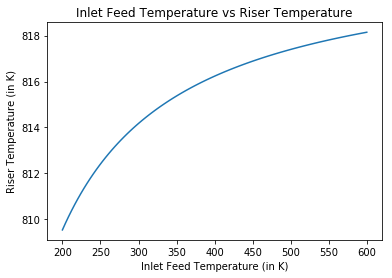

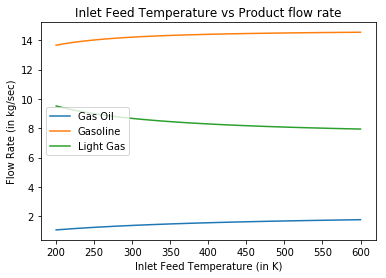

In [53]:
import numpy as np
import scipy
from scipy.integrate import odeint 
from scipy import integrate
import matplotlib.pyplot as py
import timeit
from scipy.optimize import fsolve

Q_overall = 25.7 # kg/sec
Ts = 773 #K
T_gasvap = 698 #K
Hvap = 190 # kJ/kg
R = 8.413
    
#K0 for components
    
K0_ab = 1150
K0_ac = 1.79
K0_ad = 426
K0_bc = 0.00059
K0_bd = 426
alpha_0 = 3.6################################### constant given in table-1
b_1 = 37311

L_r = 33 # m- riser height


p0 = [773,698,190,1150,1.79,426,0.00059,426,3.6,37311,25.7,494,1033,0.8,6.1,67.21,59.66,47.82,30.95,68.83,57.74,393,
      795,1200,1150,151,3.3,3.3,3.3,1.087,1.9,33]

#Case 1 conditions
Cat_T = 1033 # K
   
#Residence time calculation
d_R = 0.8 # m - riser dia

v_s = 6.1 #m/sec as given in paper table 3 

    
E_coke = 67.21 # KJ/mol given in table1
E_ab = 59.66 # KJ/mol
E_bd = 47.82 
E_ac = 30.95
E_ad = 68.83
E_bc = 57.74
    
Hab = 393
Hbd = 795
Hac = 1200
Had = 1150
Hbc = 151
    
Cp_gasoil = 3.3 #kJ/kgK
Cp_gasoline = 3.3 #kJ/kgK
Cp_Lightgas = 3.3 #kJ/kgK
Cp_coke = 1.087 #kJ/kgK
Cp_steam = 1.9 #kJ/kgK

zspan  = np.linspace(0,L_r)

Temp1=[]
gasoil =[]
Gasoline_flow = []
Light_gas = []
coke=[]

f_t = np.linspace(200,600,100)
# Case 1

for Feed_T in f_t:
    

    Q = 0.945*Q_overall
    F_s = 0.055*Q_overall
    r_r = d_R/2
    R_a = (np.pi*r_r**2)/4
    vel_r = Q/R_a
    t_c = L_r/v_s
    
    def dydz(y,z):
        ya,yb,yc,yd,T = y
      
        #check whether required
        Kab = K0_ab*np.exp((E_ab)/(R*Feed_T))
        Kbd = K0_bd*np.exp((E_bd)/(R*Feed_T))
        Kac = K0_ac*np.exp((E_ac)/(R*Feed_T))
        Kad = K0_ad*np.exp((E_ad)/(R*Feed_T))
        Kbc = K0_bc*np.exp((E_bc)/(R*Feed_T))

        e = 0.8 # check the assumption

        alpha = alpha_0*np.exp(-E_coke/(R*Feed_T))
        phi = E_coke*np.exp(-alpha*t_c)

        rh_s = 960 #kg/m3

        #dydt(1) = dyadt, dydt(2) = dybdt, dydt(3) = dyddt, dydt(4) = dycdt

        dydz1 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*ya**2 # gas oil


        dydz2 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*yb-Kab*ya**2) # gasoline

        dydz3 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbd*yb+Kad*ya**2) #% light hydrocarbon gas

        dydz4 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*yb+Kac*ya**2) # coke

        dTdz = -((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((ya**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+yb*(Kbc*Hbc+Kbd*Hbd))                                                                                                       
        return dydz1, dydz2, dydz3, dydz4,dTdz
    
    
    sol, infodict = scipy.integrate.odeint(dydz,[Q,0,0,0,868],zspan,full_output=True)
    Temp1.append(sol[-1,4])
    Gasoline_flow.append(sol[-1,1])
    gasoil.append(sol[-1,0])
    Light_gas.append(sol[-1,2])
    coke.append(sol[-1,3])
py.plot(f_t,Temp1)
py.xlabel('Inlet Feed Temperature (in K)')
py.ylabel('Riser Temperature (in K)')
py.title('Inlet Feed Temperature vs Riser Temperature')
py.plot()
py.savefig('16.png')
py.show()

py.plot(f_t,gasoil,f_t,Gasoline_flow,f_t,Light_gas)
py.xlabel('Inlet Feed Temperature (in K)')
py.ylabel('Flow Rate (in kg/sec)')
py.title('Inlet Feed Temperature vs Product flow rate')
py.legend(['Gas Oil','Gasoline','Light Gas'])
py.plot()
py.savefig('17.png')
py.show()


## 6.2 Variation of Feed flow rate - Riser temperature

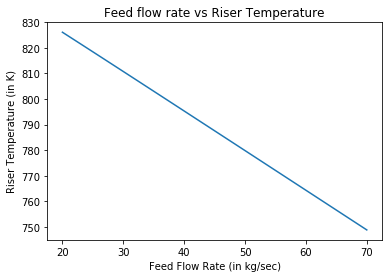

In [54]:
import numpy as np
import scipy
from scipy.integrate import odeint 
from scipy import integrate
import matplotlib.pyplot as py
import timeit
from scipy.optimize import fsolve

#Q_overall = 25.7 # kg/sec
Ts = 773 #K
T_gasvap = 698 #K
Hvap = 190 # kJ/kg
R = 8.413
    
#K0 for components
    
K0_ab = 1150
K0_ac = 1.79
K0_ad = 426
K0_bc = 0.00059
K0_bd = 426
alpha_0 = 3.6
b_1 = 37311

L_r = 33 # m- riser height


p0 = [773,698,190,1150,1.79,426,0.00059,426,3.6,37311,25.7,494,1033,0.8,6.1,67.21,59.66,47.82,30.95,68.83,57.74,393,
      795,1200,1150,151,3.3,3.3,3.3,1.087,1.9,33]

#Case 1 conditions
Feed_T = 494 # K
Cat_T = 1033 # K
   
#Residence time calculation
d_R = 0.8 # m - riser dia

t_c = L_r / vel_r # residence time in riser (in sec) --- can alternativly use the superficial velocity given in te table 3
v_s = 6.1 #m/sec as given in paper table 3 

    
E_coke = 67.21 # KJ/mol given in table1
E_ab = 59.66 # KJ/mol
E_bd = 47.82 
E_ac = 30.95
E_ad = 68.83
E_bc = 57.74
    
Hab = 393
Hbd = 795
Hac = 1200
Had = 1150
Hbc = 151
    
Cp_gasoil = 3.3 #kJ/kgK
Cp_gasoline = 3.3 #kJ/kgK
Cp_Lightgas = 3.3 #kJ/kgK
Cp_coke = 1.087 #kJ/kgK
Cp_steam = 1.9 #kJ/kgK

zspan  = np.linspace(0,L_r)

Temp1=[]
gasoil =[]
Gasoline_flow = []
Light_gas = []
coke=[]

f_t = np.linspace(20,70,100)
# Case 1

for Q_overall in f_t:
    
    
    Q = 0.945*Q_overall
    F_s = 0.055*Q_overall
    r_r = d_R/2
    R_a = (np.pi*r_r**2)/4
    vel_r = Q/R_a
    t_c = L_r/v_s
    
    def dydz(y,z):
        ya,yb,yc,yd,T = y
      
        #check whether required
        Kab = K0_ab*np.exp((E_ab)/(R*Feed_T))
        Kbd = K0_bd*np.exp((E_bd)/(R*Feed_T))
        Kac = K0_ac*np.exp((E_ac)/(R*Feed_T))
        Kad = K0_ad*np.exp((E_ad)/(R*Feed_T))
        Kbc = K0_bc*np.exp((E_bc)/(R*Feed_T))

        e = 0.8 # check the assumption

        alpha = alpha_0*np.exp(-E_coke/(R*Feed_T))
        phi = E_coke*np.exp(-alpha*t_c)

        rh_s = 960 #kg/m3

        #dydt(1) = dyadt, dydt(2) = dybdt, dydt(3) = dyddt, dydt(4) = dycdt

        dydz1 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*ya**2 # gas oil


        dydz2 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*yb-Kab*ya**2) # gasoline

        dydz3 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbd*yb+Kad*ya**2) #% light hydrocarbon gas

        dydz4 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*yb+Kac*ya**2) # coke

        dTdz = -((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((ya**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+yb*(Kbc*Hbc+Kbd*Hbd))                                                                                                       
        return dydz1, dydz2, dydz3, dydz4,dTdz
    
    
    sol, infodict = scipy.integrate.odeint(dydz,[Q,0,0,0,868],zspan,full_output=True)
    Temp1.append(sol[-1,4])
    Gasoline_flow.append(sol[-1,1])
    gasoil.append(sol[-1,0])
    Light_gas.append(sol[-1,2])
    coke.append(sol[-1,3])
    
py.plot(f_t,Temp1)
py.xlabel('Feed Flow Rate (in kg/sec)')
py.ylabel('Riser Temperature (in K)')
py.title('Feed flow rate vs Riser Temperature')
py.plot()
py.savefig('18.png')
py.show()



## 6.3 Variation of Riser length on Product flow

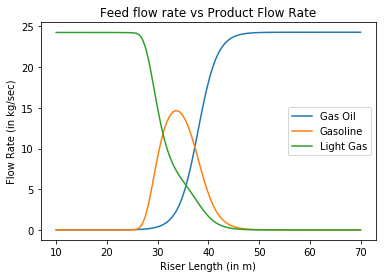

The maximum value of Gasoline flow is obtained for Riser Height of 33.6364 m 


In [55]:
import numpy as np
import scipy
from scipy.integrate import odeint 
from scipy import integrate
import matplotlib.pyplot as py
import timeit
from scipy.optimize import fsolve

Q_overall = 25.7 # kg/sec
Ts = 773 #K
T_gasvap = 698 #K
Hvap = 190 # kJ/kg
R = 8.413
    
#K0 for components
    
K0_ab = 1150
K0_ac = 1.79
K0_ad = 426
K0_bc = 0.00059
K0_bd = 426
alpha_0 = 3.6
b_1 = 37311

#L_r = 33 # m- riser height


p0 = [773,698,190,1150,1.79,426,0.00059,426,3.6,37311,25.7,494,1033,0.8,6.1,67.21,59.66,47.82,30.95,68.83,57.74,393,
      795,1200,1150,151,3.3,3.3,3.3,1.087,1.9,33]

#Case 1 conditions
Feed_T = 494 # K
Cat_T = 1033 # K
   
#Residence time calculation
d_R = 0.8 # m - riser dia

t_c = L_r / vel_r # residence time in riser (in sec) --- can alternativly use the superficial velocity given in te table 3
v_s = 6.1 #m/sec as given in paper table 3 

    
E_coke = 67.21 # KJ/mol given in table1
E_ab = 59.66 # KJ/mol
E_bd = 47.82 
E_ac = 30.95
E_ad = 68.83
E_bc = 57.74
    
Hab = 393
Hbd = 795
Hac = 1200
Had = 1150
Hbc = 151
    
Cp_gasoil = 3.3 #kJ/kgK
Cp_gasoline = 3.3 #kJ/kgK
Cp_Lightgas = 3.3 #kJ/kgK
Cp_coke = 1.087 #kJ/kgK
Cp_steam = 1.9 #kJ/kgK



Temp1=[]
gasoil =[]
Gasoline_flow = []
Light_gas = []
coke=[]

f_t = np.linspace(10,70,100)
# Case 1

#####################solving the boundary condition 
for L_r in f_t:
    zspan  = np.linspace(0,L_r)
    
    Q = 0.945*Q_overall
    F_s = 0.055*Q_overall
    r_r = d_R/2
    R_a = (np.pi*r_r**2)/4
    vel_r = Q/R_a
    t_c = L_r/v_s
    
    def dydz(y,z):
        ya,yb,yc,yd,T = y
      
        #check whether required
        Kab = K0_ab*np.exp((E_ab)/(R*Feed_T))
        Kbd = K0_bd*np.exp((E_bd)/(R*Feed_T))
        Kac = K0_ac*np.exp((E_ac)/(R*Feed_T))
        Kad = K0_ad*np.exp((E_ad)/(R*Feed_T))
        Kbc = K0_bc*np.exp((E_bc)/(R*Feed_T))

        e = 0.8 # check the assumption

        alpha = alpha_0*np.exp(-E_coke/(R*Feed_T))
        phi = E_coke*np.exp(-alpha*t_c)

        rh_s = 960 #kg/m3

        #dydt(1) = dyadt, dydt(2) = dybdt, dydt(3) = dyddt, dydt(4) = dycdt

        dydz1 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*ya**2 # gas oil


        dydz2 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*yb-Kab*ya**2) # gasoline

        dydz3 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbd*yb+Kad*ya**2) #% light hydrocarbon gas

        dydz4 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*yb+Kac*ya**2) # coke

        dTdz = -((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((ya**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+yb*(Kbc*Hbc+Kbd*Hbd))                                                                                                       
        return dydz1, dydz2, dydz3, dydz4,dTdz
    
    
    sol, infodict = scipy.integrate.odeint(dydz,[Q,0,0,0,868],zspan,full_output=True)
    Temp1.append(sol[-1,4])
    Gasoline_flow.append(sol[-1,1])
    gasoil.append(sol[-1,0])
    Light_gas.append(sol[-1,2])
    coke.append(sol[-1,3])


py.plot(f_t,gasoil,f_t,Gasoline_flow,f_t,Light_gas)
py.xlabel('Riser Length (in m)')
py.ylabel('Flow Rate (in kg/sec)')
py.legend(['Gas Oil','Gasoline','Light Gas'])
py.title('Feed flow rate vs Product Flow Rate')
py.plot()
py.savefig('20.png')
py.show()

print ('The maximum value of Gasoline flow is obtained for Riser Height of {0:1.4f} m '.format(np.double(f_t[np.where(np.double(Gasoline_flow) > 14.6674446)])))


It can be noted from the graph that the Gasoline production is maximum at riser height of 33.636 m is required for maximizing the flow rate of Gasoline, which is the desired product. 

## 6.4 Gasoline production at varying inlet flow rate for different riser heights 

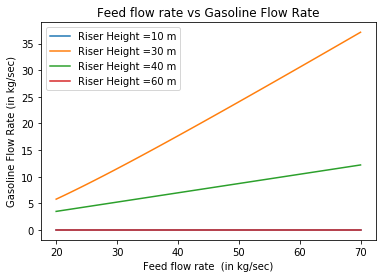

In [29]:
import numpy as np
import scipy
from scipy.integrate import odeint 
from scipy import integrate
import matplotlib.pyplot as py
import timeit
from scipy.optimize import fsolve

Q_overall = 25.7 # kg/sec
Ts = 773 #K
T_gasvap = 698 #K
Hvap = 190 # kJ/kg
R = 8.413
    
#K0 for components
    
K0_ab = 1150
K0_ac = 1.79
K0_ad = 426
K0_bc = 0.00059
K0_bd = 426
alpha_0 = 3.6
b_1 = 37311

#L_r = 33 # m- riser height


p0 = [773,698,190,1150,1.79,426,0.00059,426,3.6,37311,25.7,494,1033,0.8,6.1,67.21,59.66,47.82,30.95,68.83,57.74,393,
      795,1200,1150,151,3.3,3.3,3.3,1.087,1.9,33]

#Case 1 conditions
Feed_T = 494 # K
Cat_T = 1033 # K
   
#Residence time calculation
d_R = 0.8 # m - riser dia
v_s = 6.1 #m/sec as given in paper table 3 

    
E_coke = 67.21 # KJ/mol given in table1
E_ab = 59.66 # KJ/mol
E_bd = 47.82 
E_ac = 30.95
E_ad = 68.83
E_bc = 57.74
    
Hab = 393
Hbd = 795
Hac = 1200
Had = 1150
Hbc = 151
    
Cp_gasoil = 3.3 #kJ/kgK
Cp_gasoline = 3.3 #kJ/kgK
Cp_Lightgas = 3.3 #kJ/kgK
Cp_coke = 1.087 #kJ/kgK
Cp_steam = 1.9 #kJ/kgK



Temp1=[]
gasoil =[]
Gasoline_flow = []
Light_gas = []
coke=[]

f_t = [10,30,40,60]
# Case 1

#####################solving the boundary condition 
for L_r in f_t:
    f_t1 = np.linspace(20,70,100)
    zspan  = np.linspace(0,L_r)
    for Q_overall in f_t1:
        

        Q = 0.945*Q_overall
        F_s = 0.055*Q_overall
        r_r = d_R/2
        R_a = (np.pi*r_r**2)/4
        vel_r = Q/R_a
        t_c = L_r/v_s

        def dydz(y,z):
            ya,yb,yc,yd,T = y

            #check whether required
            Kab = K0_ab*np.exp((E_ab)/(R*Feed_T))
            Kbd = K0_bd*np.exp((E_bd)/(R*Feed_T))
            Kac = K0_ac*np.exp((E_ac)/(R*Feed_T))
            Kad = K0_ad*np.exp((E_ad)/(R*Feed_T))
            Kbc = K0_bc*np.exp((E_bc)/(R*Feed_T))

            e = 0.8 # check the assumption

            alpha = alpha_0*np.exp(-E_coke/(R*Feed_T))
            phi = E_coke*np.exp(-alpha*t_c)

            rh_s = 960 #kg/m3

            #dydt(1) = dyadt, dydt(2) = dybdt, dydt(3) = dyddt, dydt(4) = dycdt

            dydz1 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kab+Kac+Kad)*ya**2 # gas oil


            dydz2 = -((phi*R_a*(1-e))*rh_s*L_r/Q)*((Kbc+Kbd)*yb-Kab*ya**2) # gasoline

            dydz3 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbd*yb+Kad*ya**2) #% light hydrocarbon gas

            dydz4 = ((phi*R_a*(1-e))*rh_s*L_r/Q)*(Kbc*yb+Kac*ya**2) # coke

            dTdz = -((phi*(1-e)*rh_s*L_r*R_a)/(Q*10**1.1*(Cp_gasoil+Cp_gasoline+Cp_Lightgas+Cp_coke+Cp_steam)))*(((ya**2)*(Kab*Hab)+(Kac*Hac)+(Kad*Had))+yb*(Kbc*Hbc+Kbd*Hbd))                                                                                                       
            return dydz1, dydz2, dydz3, dydz4,dTdz
    
    
        sol, infodict = scipy.integrate.odeint(dydz,[Q,0,0,0,868],zspan,full_output=True)
        Temp1.append(sol[-1,4])
        Gasoline_flow.append(sol[-1,1])
        gasoil.append(sol[-1,0])
        Light_gas.append(sol[-1,2])
        coke.append(sol[-1,3])

    py.plot(f_t1,Gasoline_flow,'-')
    Temp1=[]
    gasoil =[]
    Gasoline_flow = []
    Light_gas = []
    coke=[]

py.xlabel('Feed flow rate  (in kg/sec)')
py.ylabel('Gasoline Flow Rate (in kg/sec)')
py.legend(['Riser Height =10 m','Riser Height =30 m','Riser Height =40 m','Riser Height =60 m'])
py.title('Feed flow rate vs Gasoline Flow Rate')
py.savefig('21.png')
py.show()




As it can observed from previous plot the maximum Gasoline production is for riser height in the range of 30 m. But from this interactive plot it can be noted that increase in Gasoline flow is increasing at a higher slope for riser height of 30m.